# IEEE_CIS Fraud Detection Kaggle Competition
***

Contact: <arlens.zeqollari@gmail.com>
***
Competition Information: https://www.kaggle.com/c/ieee-fraud-detection
***

<img src="IEEE-CIS.jpg" width="700" height="300">

## Background

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

**Categorical Features - Transaction**
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

**Categorical Features - Identity**
* DeviceType
* DeviceInfo
* id_12 - id_38
* The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

**Files**
* train_{transaction, identity}.csv - the training set
* test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
* sample_submission.csv - a sample submission file in the correct format

# Import Required Packages

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

import gc

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',1000)

# Load Data

In [2]:
# Transaction CSVs
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

# Identity CSVs - These will be merged onto the transactions to create additional features
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

# Create number of NULLS for Transaction and Identity datasets
train_transaction['Trans_num_nulls'] = train_transaction.isnull().sum(axis=1)
test_transaction['Trans_num_nulls'] = test_transaction.isnull().sum(axis=1)

train_identity['Ident_num_nulls'] = train_identity.isnull().sum(axis=1)
test_identity['Ident_num_nulls'] = test_identity.isnull().sum(axis=1)


# Sample Submissions
ss = pd.read_csv('sample_submission.csv')

print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 395)
test_transaction shape is (506691, 394)
train_identity shape is (144233, 42)
test_identity shape is (141907, 42)


## Join transaction and identity data

In [3]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

## Reduce Memory Usage

In [4]:
del train_transaction, train_identity, test_identity, test_transaction

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 652.73 Mb (66.8% reduction)
Mem. usage decreased to 567.30 Mb (66.3% reduction)


In [6]:
gc.collect()

34

# Feature Engineering

### Feature Engineering for Dubious Email Domains

In [7]:
# train['P_isproton']=(train['P_emaildomain']=='protonmail.com')
# train['R_isproton']=(train['R_emaildomain']=='protonmail.com')
# test['P_isproton']=(test['P_emaildomain']=='protonmail.com')
# test['R_isproton']=(test['R_emaildomain']=='protonmail.com')

# train['P_anonymous']=(train['P_emaildomain']=='anonymous.com')
# train['R_anonymous']=(train['R_emaildomain']=='anonymous.com')
# test['P_anonymous']=(test['P_emaildomain']=='anonymous.com')
# test['R_anonymous']=(test['R_emaildomain']=='anonymous.com')

### One-Hot Encoding for card4

In [4]:
train = pd.concat([train, pd.get_dummies(train.card4,prefix='card4')], axis=1)
test = pd.concat([test, pd.get_dummies(test.card4, prefix='card4')], axis=1)

### Create sets of user_id for identifying information

In [5]:
train['user_id'] = train['card1'].astype('str') + '_' + train['card2'].astype('str')
test['user_id'] = test['card1'].astype('str') + '_' + test['card2'].astype('str')

In [6]:
train['user_id_2'] = train['user_id'].astype('str') + '_' + train['card3'].astype('str') + '_' + train['card5'].astype('str')
test['user_id_2'] = test['user_id'].astype('str') + '_' + test['card3'].astype('str') + '_' + test['card5'].astype('str')

In [7]:
train['user_id_3'] = train['user_id_2'].astype('str') + '_' + train['addr1'].astype('str') + '_' + train['addr2'].astype('str')
test['user_id_3'] = test['user_id_2'].astype('str') + '_' + test['addr1'].astype('str') + '_' + test['addr2'].astype('str')

### TransactionAmt Aggregations

In [8]:
col = 'user_id'
temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]]).groupby(col).agg(['mean','std']).reset_index()
temp_df = pd.concat([temp_df[col],temp_df['TransactionAmt']],axis = 1)
temp_df = temp_df.rename(columns={"mean": col + '_' + "mean", "std": col + '_' + "std"})
train = pd.merge(train, temp_df, how = 'left', on = col)
test = pd.merge(test, temp_df, how = 'left', on = col)

train[col + '_' + 'TransactionAmt_diff_from_mean'] = train.TransactionAmt - train[col + '_' + 'mean']
test[col + '_' + 'TransactionAmt_diff_from_mean'] = test.TransactionAmt - test[col + '_' + 'mean']

train[col + '_' + 'TransactionAmt_std_away'] = (train.TransactionAmt - train[col + '_' + 'mean'])/train[col + '_' + 'std']
test[col + '_' + 'TransactionAmt_std_away'] = (test.TransactionAmt - test[col + '_' + 'mean'])/test[col + '_' + 'std']

In [9]:
col = 'user_id_2'
temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]]).groupby(col).agg(['mean','std']).reset_index()
temp_df = pd.concat([temp_df[col],temp_df['TransactionAmt']],axis = 1)
temp_df = temp_df.rename(columns={"mean": col + '_' + "mean", "std": col + '_' + "std"})
train = pd.merge(train, temp_df, how = 'left', on = col)
test = pd.merge(test, temp_df, how = 'left', on = col)

train[col + '_' + 'TransactionAmt_diff_from_mean'] = train.TransactionAmt - train[col + '_' + 'mean']
test[col + '_' + 'TransactionAmt_diff_from_mean'] = test.TransactionAmt - test[col + '_' + 'mean']

train[col + '_' + 'TransactionAmt_std_away'] = (train.TransactionAmt - train[col + '_' + 'mean'])/train[col + '_' + 'std']
test[col + '_' + 'TransactionAmt_std_away'] = (test.TransactionAmt - test[col + '_' + 'mean'])/test[col + '_' + 'std']

In [10]:
col = 'user_id_3'
temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]]).groupby(col).agg(['mean','std']).reset_index()
temp_df = pd.concat([temp_df[col],temp_df['TransactionAmt']],axis = 1)
temp_df = temp_df.rename(columns={"mean": col + '_' + "mean", "std": col + '_' + "std"})
train = pd.merge(train, temp_df, how = 'left', on = col)
test = pd.merge(test, temp_df, how = 'left', on = col)

train[col + '_' + 'TransactionAmt_diff_from_mean'] = train.TransactionAmt - train[col + '_' + 'mean']
test[col + '_' + 'TransactionAmt_diff_from_mean'] = test.TransactionAmt - test[col + '_' + 'mean']

train[col + '_' + 'TransactionAmt_std_away'] = (train.TransactionAmt - train[col + '_' + 'mean'])/train[col + '_' + 'std']
test[col + '_' + 'TransactionAmt_std_away'] = (test.TransactionAmt - test[col + '_' + 'mean'])/test[col + '_' + 'std']

In [11]:
del temp_df

### Function for One-Hot Encoding Top n Variables Only

In [12]:
def one_hot_top_n(train_df, test_df, n,variable):
    cols_to_keep = pd.get_dummies(train_df[train_df.isFraud == 1][variable],prefix=str(variable)).sum().sort_values(ascending=False)[:n].index.values

    train_df = pd.concat([train_df, pd.get_dummies(train_df[variable],prefix=str(variable))[cols_to_keep]], axis=1)
    test_df = pd.concat([test_df, pd.get_dummies(test_df[variable], prefix = str(variable))[cols_to_keep]], axis=1)
    print(train_df.shape)
    print(test_df.shape)
    return train_df, test_df

#### One-Hot Encode Top 10 card3 values

In [13]:
train, test = one_hot_top_n(train, test, 10,'card3')

(590540, 465)
(506691, 464)


#### One-Hot Encode Top 10 card2 values

In [14]:
train, test = one_hot_top_n(train, test, 10,'card2')

(590540, 475)
(506691, 474)


#### One-Hot Encode Top 20 card1 values

In [15]:
train, test = one_hot_top_n(train, test, 20,'card1')

(590540, 495)
(506691, 494)


#### One-Hot Encode Top 10 card5 values

In [16]:
train, test = one_hot_top_n(train, test, 10,'card5')

(590540, 505)
(506691, 504)


#### One-Hot Encode Top 10 addr1 values

In [17]:
train, test = one_hot_top_n(train, test, 10,'addr1')

(590540, 515)
(506691, 514)


#### One-Hot Encode Top 5 addr2 values

In [18]:
train, test = one_hot_top_n(train, test, 5,'addr2')

(590540, 520)
(506691, 519)


### One-Hot Encoding for ProductCD

In [19]:
train = pd.concat([train, pd.get_dummies(train.ProductCD,prefix='ProductCD')], axis=1)
test = pd.concat([test, pd.get_dummies(test.ProductCD, prefix='ProductCD')], axis=1)

### One-Hot Encoding for card6

In [20]:
train = pd.concat([train, pd.get_dummies(train.card6,prefix='card6')], axis=1)
test = pd.concat([test, pd.get_dummies(test.card6, prefix='card6')], axis=1)

### One-Hot Encoding for P_emaildomain

In [21]:
train = pd.concat([train, pd.get_dummies(train.P_emaildomain,prefix='P_emaildomain')], axis=1)
test = pd.concat([test, pd.get_dummies(test.P_emaildomain, prefix='P_emaildomain')], axis=1)

### One-Hot Encoding for R_emaildomain

In [22]:
train = pd.concat([train, pd.get_dummies(train.R_emaildomain,prefix='R_emaildomain')], axis=1)
test = pd.concat([test, pd.get_dummies(test.R_emaildomain, prefix='R_emaildomain')], axis=1)

### Feature Engineering for Transaction Day of Week and Hour of Day

In [23]:
train['Transaction_day_of_year'] = np.floor(train['TransactionDT'] / (3600 * 24)) 
test['Transaction_day_of_year'] = np.floor(test['TransactionDT'] / (3600 * 24))

train['Transaction_week_of_year'] = np.floor((train['Transaction_day_of_year'] / 7))
test['Transaction_week_of_year'] = np.floor((test['Transaction_day_of_year'] / 7))

train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

train['Transaction_hour_of_day'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour_of_day'] = np.floor(test['TransactionDT'] / 3600) % 24

train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

### Get Transactions per Week and per Day

In [24]:
temp_df = pd.concat([train[['Transaction_week_of_year','TransactionAmt']], test[['Transaction_week_of_year','TransactionAmt']]]).groupby('Transaction_week_of_year').count().reset_index()
temp_df = temp_df.rename(columns = {'TransactionAmt': "tot_transactions_for_week"})
train = pd.merge(train, temp_df, how = 'left', on = 'Transaction_week_of_year')
test = pd.merge(test, temp_df, how = 'left', on = 'Transaction_week_of_year')

In [25]:
temp_df = pd.concat([train[['Transaction_day_of_year','TransactionAmt']], test[['Transaction_day_of_year','TransactionAmt']]]).groupby('Transaction_day_of_year').count().reset_index()
temp_df = temp_df.rename(columns = {'TransactionAmt': "tot_transactions_for_day"})
train = pd.merge(train, temp_df, how = 'left', on = 'Transaction_day_of_year')
test = pd.merge(test, temp_df, how = 'left', on = 'Transaction_day_of_year')

### Find Latest Operating Systems

In [26]:
train_latest_OS_list = ['Android 8.1.0','Android 8.0.0',
                        'iOS 11.4.1','iOS 11.4.0',
                        'Windows 8','Windows 8.1',
                        'Mac OS X 10.13','Mac OS X 10_13_2','Mac OS X 10_13_3','Mac OS X 10_13_4', 'Mac OS X 10_13_5',
                        
                 ]

test_latest_OS_list = ['Android 9',
                       'iOS 12.0.1','iOS 12.1.1','iOS 12.1.2',
                       'Windows 10',
                       'Mac OS X 10.14','Mac OS X 10_14_0','Mac OS X 10_14_1','Mac OS X 10_14_2'
    
]

def set_Latest_OS_train(df):
    df['Is_Latest_OS'] = 0
    for i in df.index:
        if df.id_30[i] in train_latest_OS_list:
            df.at[i, 'Is_Latest_OS'] = 1
            
def set_Latest_OS_test(df):
    df['Is_Latest_OS'] = 0
    for i in df.index:
        if df.id_30[i] in test_latest_OS_list:
            df.at[i, 'Is_Latest_OS'] = 1
            
set_Latest_OS_train(train)
set_Latest_OS_test(test)

fraud_rate_latest = train[(train.Is_Latest_OS == 1) & (train.isFraud == 1)].isFraud.sum() / len(train[train.Is_Latest_OS == 1])
fraud_rate_old = train[(train.Is_Latest_OS == 0) & (train.isFraud == 1)].isFraud.sum() / len(train[train.Is_Latest_OS == 0])

print('Fraud rate of latest OS: ', fraud_rate_latest)
print('Fraud rate of older OS: ', fraud_rate_old)

Fraud rate of latest OS:  0.04592691920885015
Fraud rate of older OS:  0.03487839007550798


### Cleaning up *device_name* column

In [27]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    
    return df

train=setDevice(train)
test=setDevice(test)

### One-Hot Encoding for device_name

In [28]:
train = pd.concat([train, pd.get_dummies(train.device_name,prefix='device_name')], axis=1)
test = pd.concat([test, pd.get_dummies(test.device_name, prefix='device_name')], axis=1)

### One_Hot Encoding for id_30 (device OS)

In [29]:
train = pd.concat([train, pd.get_dummies(train.id_30,prefix='id_30')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_30, prefix='id_30')], axis=1)

### One_Hot Encoding for id_31 (browser)

In [30]:
train = pd.concat([train, pd.get_dummies(train.id_31,prefix='id_31')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_31, prefix='id_31')], axis=1)

### One_Hot Encoding for id_34 (match_status)

In [31]:
train = pd.concat([train, pd.get_dummies(train.id_34,prefix='id_34')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_34, prefix='id_34')], axis=1)

### One_Hot Encoding for id_33 (device resolution)

In [32]:
# train = pd.concat([train, pd.get_dummies(train.id_33,prefix='id_33')], axis=1)
# test = pd.concat([test, pd.get_dummies(test.id_33, prefix='id_33')], axis=1)

### One_Hot Encoding for id_12

In [33]:
train = pd.concat([train, pd.get_dummies(train.id_12,prefix='id_12')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_12, prefix='id_12')], axis=1)

### One_Hot Encoding for id_15

In [34]:
train = pd.concat([train, pd.get_dummies(train.id_15,prefix='id_15')], axis=1)
test = pd.concat([test, pd.get_dummies(test.id_15, prefix='id_15')], axis=1)

### One_Hot Encoding for DeviceType

In [35]:
train = pd.concat([train, pd.get_dummies(train.DeviceType,prefix='DeviceType')], axis=1)
test = pd.concat([test, pd.get_dummies(test.DeviceType, prefix='DeviceType')], axis=1)

### One_Hot Encoding for M4

In [36]:
train = pd.concat([train, pd.get_dummies(train.M4,prefix='M4')], axis=1)
test = pd.concat([test, pd.get_dummies(test.M4, prefix='M4')], axis=1)

### Create number of NaNs Feature

In [37]:
# train['num_nulls'] = train.isnull().sum(axis=1)
# test['num_nulls'] = test.isnull().sum(axis=1)

### Drop original columns that were one-hot encoded

In [38]:
cols_to_drop = ["addr1","addr2","card1","card2","card5","card3","card4","ProductCD","card6","P_emaildomain","R_emaildomain","device_name","id_12","id_15","id_30","id_31","id_33","id_34","M4","DeviceInfo","DeviceType"]
train.drop(columns = cols_to_drop,inplace=True)
test.drop(columns = cols_to_drop,inplace=True)

,TransactionID,isFraud,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,Trans_num_nulls,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_35,id_36,id_37,id_38,Ident_num_nulls,card4_american express,card4_discover,card4_mastercard,card4_visa,user_id,user_id_2,user_id_3,user_id_mean,user_id_std,user_id_TransactionAmt_diff_from_mean,user_id_TransactionAmt_std_away,user_id_2_mean,user_id_2_std,user_id_2_TransactionAmt_diff_from_mean,user_id_2_TransactionAmt_std_away,user_id_3_mean,user_id_3_std,user_id_3_TransactionAmt_diff_from_mean,user_id_3_TransactionAmt_std_away,card3_150.0,card3_185.0,card3_144.0,card3_119.0,card3_143.0,card3_146.0,card3_106.0,card3_117.0,card3_223.0,card3_102.0,card2_545.0,card2_321.0,card2_111.0,card2_555.0,card2_490.0,card2_500.0,card2_583.0,card2_408.0,card2_514.0,card2_130.0,card1_9633,card1_9500,card1_15885,card1_9026,card1_15063,card1_5812,card1_2616,card1_15066,card1_9917,card1_6019,card1_3154,card1_17188,card1_7585,card1_14276,card1_2256,card1_4504,card1_10616,card1_12695,card1_8755,card1_4461,card5_226.0,card5_224.0,card5_102.0,card5_137.0,card5_138.0,card5_195.0,card5_166.0,card5_219.0,card5_117.0,card5_162.0,addr1_204.0,addr1_325.0,addr1_299.0,addr1_330.0,addr1_264.0,addr1_272.0,addr1_441.0,addr1_337.0,addr1_315.0,addr1_123.0,addr2_87.0,addr2_60.0,addr2_96.0,addr2_65.0,addr2_10.0,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,card6_debit or credit,P_emaildomain_aim.com,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_ma

### Perform time correction on D variables

#### Correct for Time for Cumulative Variables

In [41]:
for col in ['D1','D2','D3','D4','D5','D6','D8','D10','D11','D12','D13','D14','D15']:
    # Get aggregate statistics
    temp_df = pd.concat([train[['Transaction_week_of_year',col]], test[['Transaction_week_of_year',col]]]).groupby('Transaction_week_of_year').mean().reset_index()
    temp_df = temp_df.rename({col: col + '_mean_of_week'}, axis = 1)
    train = pd.merge(train, temp_df, how = 'left', on = 'Transaction_week_of_year')
    test = pd.merge(test, temp_df, how = 'left', on = 'Transaction_week_of_year')
    
    # perform correction
    train[col + '_corrected'] = train[col] - train[col + '_mean_of_week']
    test[col + '_corrected'] = test[col] - test[col + '_mean_of_week']
    
    # Drop original columns
    train = train.drop(col, axis = 1)
    test = test.drop(col, axis = 1)
    
del temp_df

# Data Processing

## Drop columns with >90% missing values

In [42]:
print('train shape was {}'.format(train.shape))

perc_thresh = .10
thresh_train = len(train) * perc_thresh
train = train.dropna(thresh = thresh_train, axis = 'columns')

print('train shape is {}'.format(train.shape))

train shape was (590540, 830)
train shape is (590540, 830)


In [43]:
current_test_columns = test.columns
cols_to_keep = []
cols_to_keep = [x for x in train.columns if x != 'isFraud' and x in current_test_columns]

test = test[cols_to_keep]
cols_to_keep.append('isFraud')
train = train[cols_to_keep]

print('train shape is {}'.format(train.shape))
print('test shape is {}'.format(test.shape))

train shape is (590540, 830)
test shape is (506691, 829)


## Drop columns with >95% repeated values

In [ ]:
def get_repeated_columns(df):
    cols_to_drop = [col for col in df.columns if (df[col].value_counts(dropna=False, normalize = True).values[0] > 0.95) & (col != 'isFraud')]
    print(cols_to_drop)
    return cols_to_drop

cols_to_drop = get_repeated_columns(train)

train = train.drop(cols_to_drop, axis = 1)
test = test.drop(cols_to_drop, axis = 1)

print('train shape is {}'.format(train.shape))
print('test shape is {}'.format(test.shape))

## Fill N/A with -999

In [44]:
train = train.fillna(-999)
test = test.fillna(-999)

## Prepare data for validation / modeling

In [45]:
X = train.drop(['isFraud','TransactionID','TransactionDT'],axis='columns')

In [46]:
test = test.drop(['TransactionID','TransactionDT'],axis='columns')

In [47]:
y = train['isFraud']

## Encode categorical variables

In [48]:
for f in X.columns:
    if X[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X[f].values) + list(test[f].values))
        X[f] = lbl.transform(list(X[f].values))
        test[f] = lbl.transform(list(test[f].values))

In [49]:
X.head()

,TransactionAmt,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D9,M1,M2,M3,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,Trans_num_nulls,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_16,id_17,id_19,id_20,id_28,id_29,id_32,id_35,id_36,id_37,id_38,Ident_num_nulls,card4_american express,card4_discover,card4_mastercard,card4_visa,user_id,user_id_2,user_id_3,user_id_mean,user_id_std,user_id_TransactionAmt_diff_from_mean,user_id_TransactionAmt_std_away,user_id_2_mean,user_id_2_std,user_id_2_TransactionAmt_diff_from_mean,user_id_2_TransactionAmt_std_away,user_id_3_mean,user_id_3_std,user_id_3_TransactionAmt_diff_from_mean,user_id_3_TransactionAmt_std_away,card3_150.0,card3_185.0,card3_144.0,card3_119.0,card3_143.0,card3_146.0,card3_106.0,card3_117.0,card3_223.0,card3_102.0,card2_545.0,card2_321.0,card2_111.0,card2_555.0,card2_490.0,card2_500.0,card2_583.0,card2_408.0,card2_514.0,card2_130.0,card1_9633,card1_9500,card1_15885,card1_9026,card1_15063,card1_5812,card1_2616,card1_15066,card1_9917,card1_6019,card1_3154,card1_17188,card1_7585,card1_14276,card1_2256,card1_4504,card1_10616,card1_12695,card1_8755,card1_4461,card5_226.0,card5_224.0,card5_102.0,card5_137.0,card5_138.0,card5_195.0,card5_166.0,card5_219.0,card5_117.0,card5_162.0,addr1_204.0,addr1_325.0,addr1_299.0,addr1_330.0,addr1_264.0,addr1_272.0,addr1_441.0,addr1_337.0,addr1_315.0,addr1_123.0,addr2_87.0,addr2_60.0,addr2_96.0,addr2_65.0,addr2_10.0,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,card6_charge card,card6_credit,card6_debit,P_emaildomain_aim.com,P_emaildomain_anonymous.com,P_emaildomain_aol.com,P_emaildomain_att.net,P_emaildomain_bellsouth.net,P_emaildomain_cableone.net,P_emaildomain_centurylink.net,P_emaildomain_cfl.rr.com,P_emaildomain_charter.net,P_emaildomain_comcast.net,P_emaildomain_cox.net,P_emaildomain_earthlink.net,P_emaildomain_embarqmail.com,P_emaildomain_frontier.com,P_emaildomain_frontiernet.net,P_emaildomain_gmail,P_emaildomain_gmail.com,P_emaildomain_gmx.de,P_emaildomain_hotmail.co.uk,P_emaildomain_hotmail.com,P_emaildomain_hotmail.de,P_emaildomain_hotmail.es,P_emaildomain_hotmail.fr,P_emaildomain_icloud.com,P_emaildomain_juno.com,P_emaildomain_live.com,P_emaildomain_live.com.mx,P_emaildomain_live.fr,P_emaildomain_mac.com,P_emaildomain_mail.com,P_emaildomain_me.com,P_emaildomain_msn.com,P_emaildomain_netzero.com,P_emaildomain_netzero.net,P_emaildomain_optonline.net,P_emaildomain_outloo

# Build and Tune Models

## Split dataset into training set and validation set

In [ ]:
# Temporary hyperparameter tuning on only 50% of training dataset
X = X.sample(frac=0.50,replace='False',random_state=10)
y = y[X.index]

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state = 42)

## Build Models

### AdaBoost Classifier

In [ ]:
ABC = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=200,
    learning_rate=1)
ABC.fit(X_train, y_train)

In [ ]:
#y_val_pred = ABC.predict(X_val)
y_val_pred_proba = ABC.predict_proba(X_val)

### xgBoost Classifier

In [53]:
# clf = xgb.XGBClassifier(
#     n_estimators=500,
#     max_depth=5,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.5,
#     missing=-999,
#     nthread = 4,
#     n_jobs = 4,
#     random_state=10,
#     verbosity = 2
# )

clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.90,
    colsample_bytree=0.50,
    gamma=8,
    missing=-999,
    nthread = 2,
    n_jobs = 2,
    random_state=10,
    tree_method = 'gpu_hist',
    verbosity = 3,
)

In [54]:
clf.fit(X_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=8,
       learning_rate=0.05, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=-999, n_estimators=1000, n_jobs=2,
       nthread=2, objective='binary:logistic', random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=3)

In [55]:
y_val_pred_proba = clf.predict_proba(X_val)

### ROC Curve

In [56]:
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_val, y_val_pred_proba[:,1])

# Print roc_auc_score
print('ROC AUC score: {:.4f}'.format(ada_roc_auc))

ROC AUC score: 0.9708


In [57]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba[:,1])

In [58]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "b:", label=label, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.title('ROC Curve')
    plt.legend()

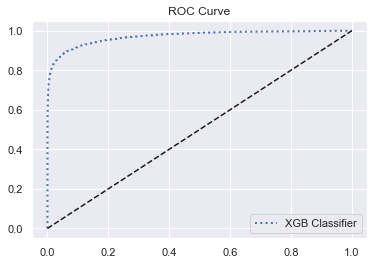

In [59]:
plot_roc_curve(fpr, tpr, label='XGB Classifier')
plt.show()

### Hyperparameter Tuning

#### Adaboost

In [ ]:
param_grid = {
 'n_estimators': [500,750],
 'learning_rate' : [.01, .1, 1],
 }

ABC = AdaBoostClassifier()

grid_search = GridSearchCV(ABC, param_grid, 
                           cv=3, scoring='roc_auc',
                           n_jobs = -1, verbose=True)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

#### xgBoost

In [ ]:
param_grid = {
    'n_estimators':[500,],
    'max_depth':[10],
    'learning_rate':[0.1],
    'subsample':[0.95],
    'colsample_bytree':[0.5],
    'gamma': [4,8,10,12],
 }

clf = xgb.XGBClassifier(
    missing=-999,
    nthread=1,
    n_jobs = 1,
    random_state=10,
    tree_method = 'gpu_hist',
    verbosity = 1,
)

grid_search = GridSearchCV(clf, param_grid, n_jobs = 1,
                           cv= 8, scoring='roc_auc', verbose=3)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending = False)

In [ ]:
pd.DataFrame(grid_search.cv_results_).plot(x = 'param_max_depth',y ='mean_test_score', figsize = (12,4))

In [ ]:
pd.DataFrame(grid_search.cv_results_).plot(x = 'param_subsample',y ='mean_test_score', figsize = (12,4))

In [ ]:
pd.DataFrame(grid_search.cv_results_).plot(x = 'param_colsample_bytree',y ='mean_test_score', figsize = (12,4))

In [ ]:
pd.DataFrame(grid_search.cv_results_).plot(x = 'param_n_estimators',y ='mean_test_score', figsize = (12,4))

In [ ]:
grid_search.best_score_

# Build Final Predictions

## Train and Fit on Full Training Data

#### ADABOOST

In [ ]:
ABC = AdaBoostClassifier(
    n_estimators=500,
    learning_rate=1)
ABC.fit(X, y)

In [ ]:
#y_test_pred = ABC.predict(test)
y_test_pred_proba = ABC.predict_proba(test)

#### XGBOOST

In [56]:
# Training with no class weights
# clf = xgb.XGBClassifier(
#     n_estimators=500,
#     max_depth=5,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.5,
#     missing=-999,
#     nthread = 4,
#     n_jobs = 4,
#     random_state=10,
#     verbosity = 2
# )

# Training with class weights
# clf = xgb.XGBClassifier(
#     n_estimators=1000,
#     max_depth=10,
#     learning_rate=0.1,
#     subsample=0.95,
#     colsample_bytree=0.5,
#     missing=-999,
#     nthread = 4,
#     n_jobs = 4,
#     random_state=10,
#     verbosity = 2,
#     scale_pos_weight=len(y[y==0])/len(y[y==1])
# )

clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.90,
    colsample_bytree=0.50,
    gamma=8,
    missing=-999,
    nthread = 4,
    n_jobs = 4,
    random_state=10,
    tree_method = 'gpu_hist',
    verbosity = 3,
)

In [57]:
clf.fit(X, y, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=8,
       learning_rate=0.05, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=-999, n_estimators=1000, n_jobs=4,
       nthread=4, objective='binary:logistic', random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, tree_method='gpu_hist', verbosity=3)

In [58]:
y_test_pred_proba = clf.predict_proba(test)

# Write Output

In [59]:
ss['isFraud'] = y_test_pred_proba[:,1]
ss.to_csv('XGB Model v22.csv',index=False)

### Last Corrections/Adjustments due to Domain Knowledge

Fraud during the holidays increases ~31% when compared to fraud throughout the year.

In [ ]:
# for prob in y_test_pred_proba[:,1]:
#     if prob * 2 <= 1:
#         y_test_pred_proba[:,1] = prob * 2

# EDA and Improvements/Experimentation

## What features were seemingly important?

#### ADABOOST

In [ ]:
importances = pd.Series(ABC.feature_importances_, index = X.columns).sort_values()
importances.plot(kind = 'barh',figsize=[18,100]);

#### XGBOOST

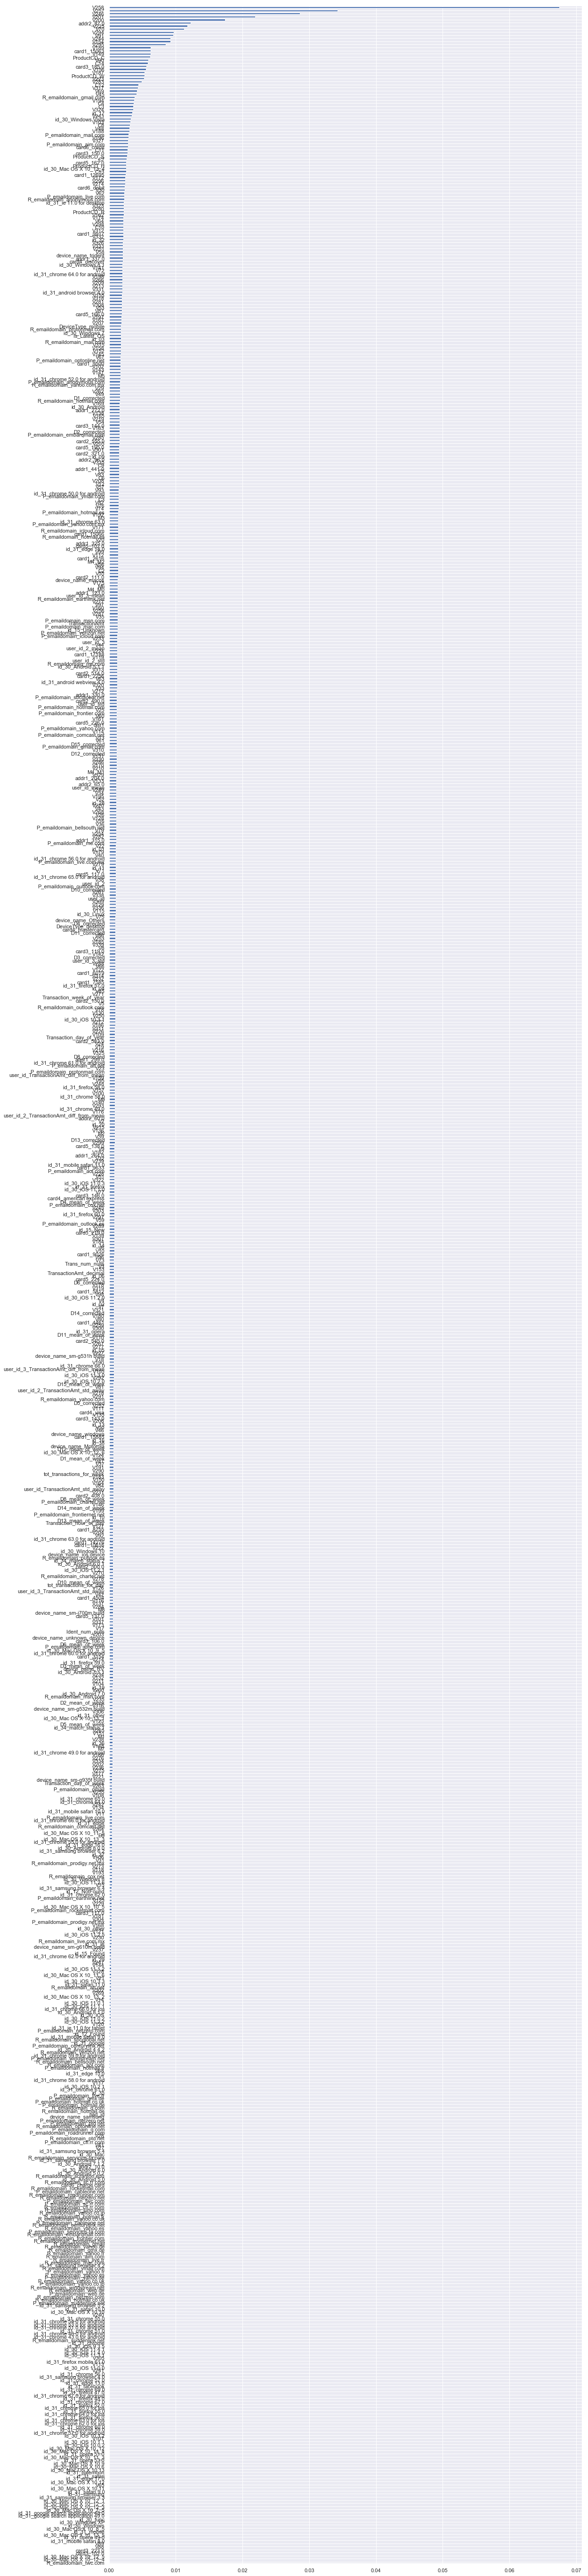

In [54]:
importances = pd.Series(clf.feature_importances_, index = X.columns).sort_values()
importances.plot(kind = 'barh',figsize=[18,100]);

In [55]:
print(X.shape)
print(test.shape)

for col in importances.index[0:100]:
    X = X.drop(col, axis = 'columns')
    test = test.drop(col, axis = 'columns')
    print('dropped: ', col)
print(X.shape)
print(test.shape)

(590540, 827)
(506691, 827)
dropped:  R_emaildomain_twc.com
dropped:  id_30_Mac OS X 10_12_4
dropped:  id_30_Mac OS X 10_12_5
dropped:  card3_102.0
dropped:  card3_223.0
dropped:  V88
dropped:  V89
dropped:  id_31_mobile safari 8.0
dropped:  id_31_opera 49.0
dropped:  id_30_Mac OS X 10_13_5
dropped:  id_31_mobile
dropped:  id_30_Mac OS X 10_8_5
dropped:  id_30_Windows
dropped:  id_30_Windows XP
dropped:  id_30_func
dropped:  id_31_google search application 49.0
dropped:  id_31_google search application 48.0
dropped:  id_30_Mac OS X 10_7_5
dropped:  id_30_Mac OS X 10_12_3
dropped:  id_30_Mac OS X 10_12_2
dropped:  id_30_Mac OS X 10_12_1
dropped:  id_31_samsung browser 3.3
dropped:  id_31_samsung
dropped:  id_31_safari 9.0
dropped:  id_30_Mac OS X 10.11
dropped:  V65
dropped:  id_30_Mac OS X 10.12
dropped:  id_31_edge 17.0
dropped:  id_31_safari
dropped:  id_31_palemoon
dropped:  id_30_Mac OS X 10.13
dropped:  id_30_Mac OS X 10.6
dropped:  id_30_Mac OS X 10.9
dropped:  id_31_opera 53.0
d

In [ ]:
clf.get_booster().get_score(importance_type = 'cover')

## Let's compare distributions of Fraudulent and Non-Fraudulent Transactions for some of the important variables

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].card1,kde=True,label = 'not fraud')
sns.distplot(X[y==1].card1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].card2.dropna(),kde=True,label = 'not fraud')
sns.distplot(X[y==1].card2.dropna(),kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(np.log10(X[y==0].TransactionAmt),kde=True,label = 'not fraud')
sns.distplot(np.log10(X[y==1].TransactionAmt),kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(np.log(X[y==0]).C14,kde=True,label = 'not fraud')
sns.distplot(np.log(X[y==1]).C14,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].C1,kde=True,label = 'not fraud')
sns.distplot(X[y==1].C1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].ProductCD,kde=True,label = 'not fraud')
sns.distplot(X[y==1].ProductCD,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))
sns.distplot(X[y==0].D1,kde=True,label = 'not fraud')
sns.distplot(X[y==1].D1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
sns.distplot(X.TransactionDT, kde=False, label = 'train set')
sns.distplot(test.TransactionDT,kde=False, color='red',label = 'test set')
plt.legend();

**We see that the dataset was split (Train and Test) by using the TransactionDT column. We should remove this from model training!**

In [ ]:
sns.distplot(X.TransactionID, kde=False, label = 'train set')
sns.distplot(test.TransactionID,kde=False, color='red',label = 'test set')
plt.legend();

**We see the same split with the TransactionID column. This can also be removed from model training**

In [ ]:
train.head()

In [ ]:
list(train.columns)

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D1.dropna())
z0 = z0[~z0.isin([-np.inf])]

z1 = np.log(X[y==1].D1.dropna())
z1 = z1[~z1.isin([-np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C13.dropna())
z0 = z0[~z0.isin([-np.inf])]

z1 = np.log(X[y==1].C13.dropna())
z1 = z1[~z1.isin([-np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D2.dropna())
z0 = z0[~z0.isin([-np.inf])]

z1 = np.log(X[y==1].D2.dropna())
z1 = z1[~z1.isin([-np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C8.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf])]

z1 = np.log(X[y==1].C8.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V315.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf])]

z1 = np.log(X[y==1].V315.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C5.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf])]

z1 = np.log(X[y==1].C5.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].num_nulls.dropna()
#z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].num_nulls.dropna()
#z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].Transaction_hour_of_day.dropna()
#z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].Transaction_hour_of_day.dropna()
#z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C2.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].C2.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();


In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D7.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].D7.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();


In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V45.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V45.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].D8.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].D8.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V333.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V333.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].C11.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].C11.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V265.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V265.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V189.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V189.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].D4.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].D4.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V318.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V318.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].V29.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].V29.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].C9.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].C9.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V82.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V82.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].D10.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].D10.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V274.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V274.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].D4.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].D4.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].num_nulls.dropna().astype(float)
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].num_nulls.dropna().astype(float)
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log(X[y==0].V318.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log(X[y==1].V318.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = X[y==0].V29.dropna()
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = X[y==1].V29.dropna()
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].C9.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].C9.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V82.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V82.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].D10.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].D10.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(X[y==0].V274.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(X[y==1].V274.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud')
sns.distplot(z1,kde=True,color='red',label = 'fraud')
plt.legend();

In [ ]:
plt.figure(figsize=(14,6))

z0 = np.log10(train[train.isFraud==0].V258.dropna())
z0 = z0[~z0.isin([-np.inf,np.inf,-999])]

z1 = np.log10(train[train.isFraud==1].V258.dropna())
z1 = z1[~z1.isin([-np.inf,np.inf,-999])]

sns.distplot(z0,kde=True,label = 'not fraud',bins=50)
sns.distplot(z1,kde=True,color='red',label = 'fraud',bins=50)
plt.legend();

In [ ]:
train[train.V258 == 1].isFraud.sum() / len(train[train.V258 == 1])

In [ ]:
train[train.V258 == 0].isFraud.sum() / len(train[train.V258 == 0])

### Correlation Matrix for V Variables

In [ ]:
V_df = train.filter(like='V', axis=1)
V_df = pd.concat([train.isFraud,V_df],axis = 1)
V_df_corr = V_df.corr()

In [ ]:
plt.figure(figsize = (300,300))
sns.heatmap(V_df_corr,xticklabels=V_df_corr.columns, yticklabels=V_df_corr.columns, annot=False);

### Are C Variable Interactions of any use?

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
C_df = train.filter(regex='^C', axis=1)
C_df = pd.concat([train.isFraud,C_df],axis = 1)
C_df.head()

In [ ]:
# Create interaction terms
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
C_inter = pd.DataFrame(interaction.fit_transform(C_df))
C_inter.head()

In [ ]:
for col in C_inter.columns:
    if col > 28:
        print('correlation: #', col, '  :',np.abs(np.corrcoef(x = C_inter[col], y = C_inter[0])[0,1]))

### Aggregate Feature Engineering

In [ ]:
train_transaction.head()

In [ ]:
train_transaction.groupby(by='card6').mean()

In [ ]:
plt.figure(figsize=(15,10))
#sns.scatterplot(x="TransactionDT", y="D1", hue="isFraud", linewidth=0, data=train[train.D1 >= 0]);
sns.scatterplot(x="TransactionDT", y="D1", linewidth=0, data=test[test.D1 >= 0]);

In [ ]:
test.head()

In [ ]:
train.groupby(['Transaction_week_of_year'])['isFraud'].agg(lambda x: x.sum() / x.count()).plot();

In [ ]:
train.groupby(['Transaction_day_of_year'])['isFraud'].agg(lambda x: x.sum() / x.count()).plot();

In [ ]:
train.groupby(['Transaction_hour_of_day'])['isFraud'].agg(lambda x: x.sum() / x.count()).plot();

In [ ]:
train.groupby(['ProductCD'])['isFraud'].agg(lambda x: x.sum() / x.count()).plot();

In [ ]:
var = 'user_id_2_std'
train.groupby([var])['isFraud'].agg(lambda x: x.sum() / x.count()).plot();

In [ ]:
print('train: \n' , train[var].value_counts())
print(test[var].value_counts())

In [ ]:
train[['isFraud','V132']].groupby('V132').mean()